In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from piecewise import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [3]:
tf.enable_eager_execution()

In [4]:
test = PiecewiseLinear(6,3,5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                255       
_________________________________________________________________
reshape (Reshape)            (None, 3, 5)              0         
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [5]:
val = np.array(np.random.rand(1000000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [6]:
np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1))

False

In [7]:
test = PiecewiseQuadratic(6,3,5)

In [8]:
val = np.array(np.random.rand(1000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


## Training

In [5]:
tf.disable_eager_execution()

In [3]:
sess = tf.InteractiveSession()

In [5]:
bijectors = []

for i in range(4):
    bijectors.append(PiecewiseQuadratic(2,1,16,layer_id=i))
#    bijectors.append(tfb.RealNVP(num_masked=1,
#                                 shift_and_log_scale_fn=tfb.real_nvp_default_template(
#                                     hidden_layers=[512,512])))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
test_bijector.forward_min_event_ndims

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 33)                2145      
_________________________________________________________________
reshape (Reshape)            (None, 1, 33)             0         
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
La

1

In [6]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
base_dist = tfd.Independent(distribution=base_dist,
                           reinterpreted_batch_ndims=1,
                           )
#base_dist = tfd.MultivariateNormalDiag(loc=[0., 0.])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

base_dist

<tfp.distributions.Independent 'IndependentUniform/' batch_shape=() event_shape=(2,) dtype=float32>

In [7]:
x = base_dist.sample(5000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

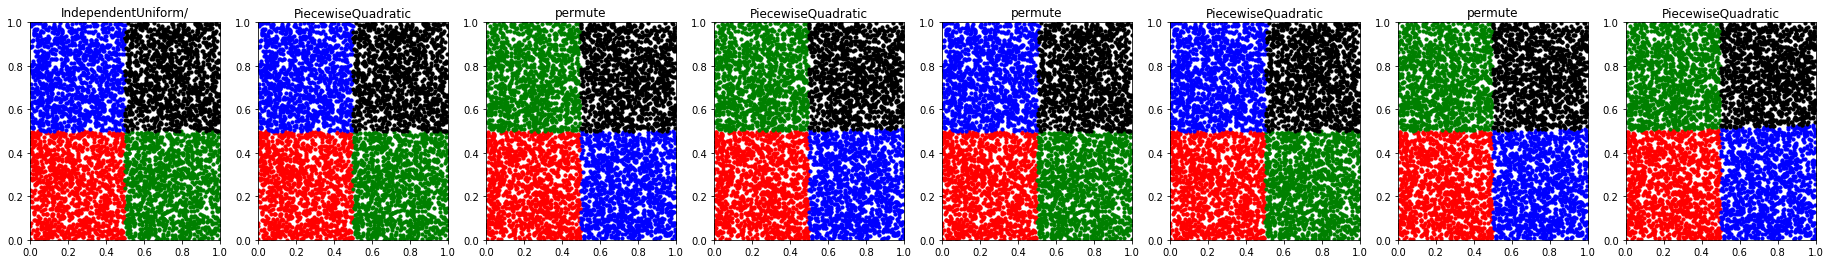

In [8]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [9]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[[array([[-0.15892445,  0.30128747,  0.23691827, -0.286921  ,  0.13207519,
         0.19646567,  0.11694264, -0.04561597,  0.06017792,  0.10214722,
        -0.21865559,  0.09195334, -0.22482139,  0.05344558,  0.2629797 ,
         0.10383984,  0.30274332, -0.0532881 ,  0.23875737,  0.19930446,
         0.2923119 , -0.2590259 , -0.1211791 , -0.23096013, -0.1119035 ,
         0.08473963,  0.1021089 ,  0.22200656, -0.13571179, -0.03440312,
         0.04594186,  0.03608298, -0.11091393, -0.23639114, -0.25903916,
         0.09863648,  0.16781431, -0.09279084, -0.2979702 , -0.05212188,
        -0.30094454,  0.30006874,  0.23479879,  0.08019945, -0.01758265,
         0.14774853,  0.03695476, -0.04198202, -0.17724726,  0.12380007,
         0.01522368, -0.12094447, -0.12147747,  0.19745529, -0.27018458,
         0.19654775,  0.21878445, -0.20645463, -0.2366257 ,  0.26121974,
         0.21667206, -0.12248535, -0.21636173, -0.05598941]],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0.,

In [10]:
def step(x,x0,k=50):
    return (1/2+1/2*tf.tanh(k*(x0-x)))

def dsigmaTrain(x):
    #return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))
    return (x[:,0]**2+x[:,1]**2)/((1-x[:,0])*(1-x[:,1]))*step(x[:,0],0.9)*step(x[:,1],0.9)

def dsigmaCircle(x):
    return (x[:,0]**2+x[:,1]**2)/((1-x[:,0])*(1-x[:,1]))*step(tf.sqrt(x[:,0]**2+x[:,1]**2),0.9)+1e-8

def dsigmaTrue(x):
    return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))

def dsigmaCircle_True(x):
    return tf.where(x[:,0]**2+x[:,1]**2 < 0.9**2*tf.ones_like(x[:,0]),(x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])),tf.zeros_like(x[:,0]))

def dsigmaTest(x):
    return 10**7*(1+(2*x[:,0]-1)**2)/((90**2-(90*2*(1-x[:,1]))**2)**2+2.5**2*90**2)

def normalChristina(x):
    return 0.8* tf.exp((-0.5*((x[:,0]-0.5)* (50 *(x[:,0]-0.5) -  15* (x[:,1]-0.5)) + (-15*(x[:,0]-0.5) + 5*(x[:,1]-0.5))* (x[:,1]-0.5))))
def normalChristina_np(x1,x2):
    return 0.8* np.exp((-0.5*((x1-0.5)* (50 *(x1-0.5) -  15* (x2-0.5)) + (-15*(x1-0.5) + 5*(x2-0.5))* (x2-0.5))))

In [29]:
x = dist.sample(5000)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaTrain(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

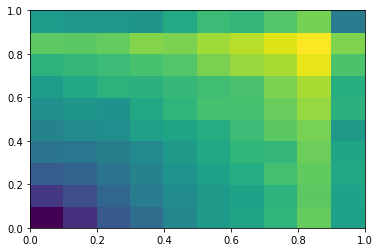

In [30]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

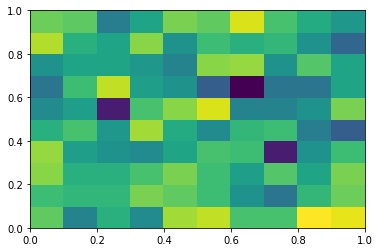

In [31]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [32]:
loss = -sess.run(tf.reduce_mean(X))
print(loss)

-5.207862e-06


In [73]:
def loss_fn(func,nsamples):
    x = dist.sample(nsamples)
    logq = dist.log_prob(x)
    p = func(x)
    q = dist.prob(x)
    xsec = p/q
    p = p/tf.reduce_mean(xsec)
    mean, var = tf.nn.moments(xsec,axes=[0])
    return tf.reduce_mean(p/q*(tf.log(p)-logq)), mean, var/nsamples

In [16]:
def loss_fn2():
    x = dist.sample(10000)
    q = tf.exp(dist.log_prob(x))
    p = dsigmaTrain(x)
    return tf.reduce_mean(p*p/q)

In [17]:
def loss_fn3():
    x = dist.sample(500)
    logq = dist.log_prob(x)
    q = dist.prob(x)
    p = normalChristina(x)
    return tf.reduce_mean(p/q*(tf.log(p)-logq)) + tf.reduce_mean(tf.square((p-q)/q))

In [18]:
def grad():
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [19]:
def loss_grad():
    with tf.GradientTape() as tape:
        x = dist.sample(1000)
        logq = dist.log_prob(x)
        p = dsigmaTest(x)
        q = tf.stop_gradient(tf.exp(logq))
        loss = tf.reduce_mean(p/q*(tf.log(p)-logq))
    grad = tape.gradient(loss,bijector.trainable_variables)
    return loss, grad

In [74]:
loss, integral, var = loss_fn(dsigmaTrain,500)
optimizer = tf.train.AdamOptimizer(1e-4)
grads = optimizer.compute_gradients(loss)
opt_op = optimizer.apply_gradients(grads)
sess.run(tf.global_variables_initializer())

0 1.0492008 5.4524226 0.23524915
500 0.301515 4.7378535 0.030821973
1000 0.11556666 4.7153006 0.009423091
1500 0.056913886 4.7239532 0.004975282
2000 0.043079246 4.713882 0.00304863
2500 0.0304019 4.711753 0.0021667222
3000 0.022312328 4.7231593 0.006797212
3500 0.017569743 4.7173395 0.0014461831
4000 0.02091478 4.717687 0.0012791255
4500 0.014117527 4.7179866 0.004772146
4999 0.017591977 4.721424 0.009190159


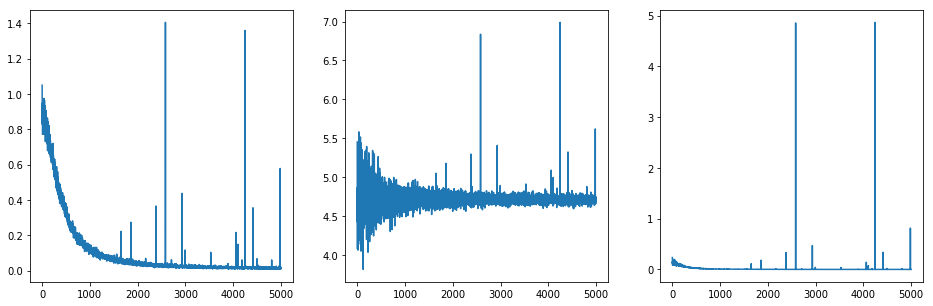

In [75]:
np_losses = []
np_integrals = []
np_vars = []
global_step = []
for epoch in range(5000):
    _, np_loss, np_integral, np_var = sess.run([opt_op, loss, integral, var])
    global_step.append(epoch)
    np_losses.append(np_loss)
    np_integrals.append(np_integral)
    np_vars.append(np_var)
    #print(np_x,np_logq)
    if(np_loss != np_loss):
        print(np_loss)
        break
    if epoch % 500 == 0:
        print(epoch, np_loss, np.mean(np_integrals[epoch-100:]), np.mean(np_vars[epoch-100:]))

print(epoch, np_loss, np.mean(np_integrals[epoch-100:]), np.mean(np_vars[epoch-100:]))
start = 0

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,5))
ax1.plot(np_losses[start:])
ax2.plot(np_integrals[start:])
ax3.plot(np_vars[start:])
plt.show()

In [63]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[[array([[-0.00694252,  0.04680765,  0.20303495,  0.31858137,  0.01554209,
        -0.13800949,  0.23613146, -0.2627265 ,  0.27624878, -0.10051434,
        -0.22525385, -0.15230699,  0.26036087,  0.2987529 , -0.16867915,
         0.15619543, -0.12534559,  0.18291612, -0.03011632, -0.20400408,
         0.04935138,  0.342294  , -0.14201416,  0.15695012, -0.15692374,
         0.05855952, -0.06280196, -0.06394124,  0.06310187, -0.13954008,
         0.2591975 , -0.14005359, -0.0429298 , -0.25621203, -0.15878022,
         0.2551528 , -0.00339425, -0.03185856, -0.10578737, -0.25160944,
        -0.18610178, -0.14278163, -0.25280792, -0.12589784, -0.12019752,
        -0.13737835, -0.26966453, -0.28278863, -0.07116574, -0.21819387,
        -0.02916537, -0.10076794, -0.16602556, -0.01873091, -0.05742757,
        -0.1525784 ,  0.32185492,  0.34476498, -0.03898582,  0.30116212,
         0.17129384, -0.2897958 ,  0.1309386 , -0.13031483]],
      dtype=float32), array([ 0.14279227,  0.12147689,  0.11

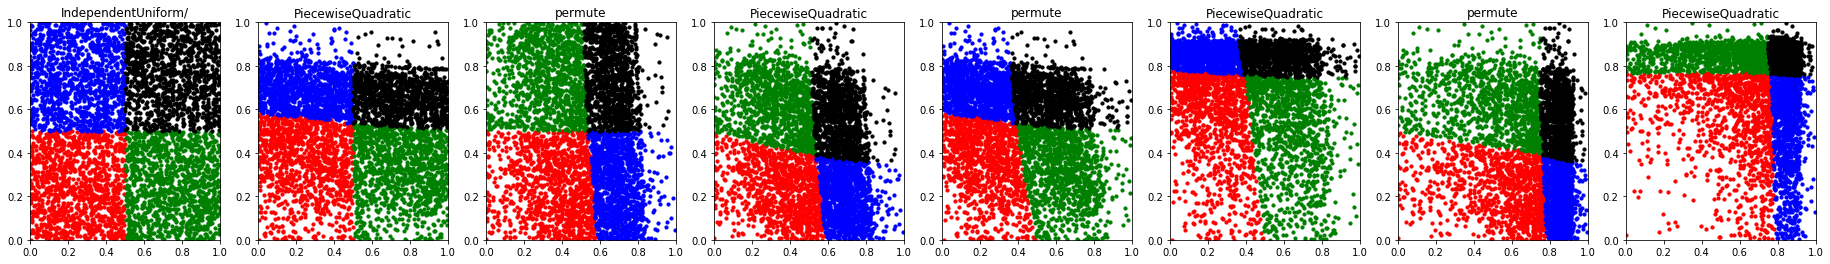

In [76]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

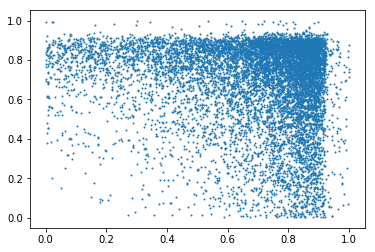

In [77]:
nsamples = 10000
x = dist.sample(nsamples)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaTrue(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

plt.scatter(xPts[:,0],xPts[:,1],s=1)
plt.show()

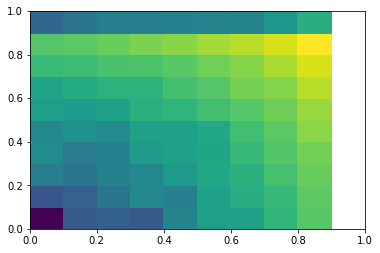

In [66]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

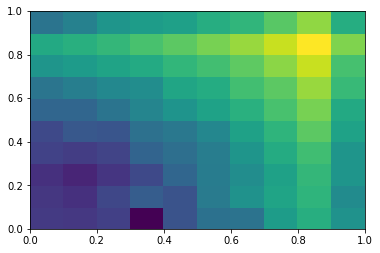

In [67]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [68]:
def step_np(x,x0,k=50):
    return (1/2+1/2*np.tanh(k*(x0-x)))

def dsigma_np(x1,x2):
    return (x1**2 + x2**2)/((1-x1)*(1-x2))

def dsigmaCircle_np(x1,x2):
    return (x1**2+x2**2)/((1-x1)*(1-x2))

def dsigmaTest_np(x1,x2):
    return (1+(2*x1-1)**2)/((90**2-(90*2*(1-x2))**2)**2+2.5**2*90**2)

In [78]:
import scipy.integrate as integrate

print('Normal Cut Integral =', integrate.dblquad(dsigma_np,0.0,0.9,0.0,0.9))
print('Circle Integral =', integrate.dblquad(dsigmaCircle_np,0.0,0.9,0.0,lambda x: np.sqrt(0.9**2-x**2)))

Normal Cut Integral = (4.594049128242379, 3.1928194812308724e-07)
Circle Integral = (1.2427983393650917, 1.4438640716722651e-08)


In [79]:
mean, var = sess.run(tf.nn.moments(dsig/q,axes=[0]))
print('xsec = %e, var = %e, stddev = %e, percent error = %e' 
      % (mean,var/nsamples,np.sqrt(var/nsamples), np.sqrt(var/nsamples)/mean*100))

xsec = 4.617617e+00, var = 3.508248e-04, stddev = 1.873032e-02, percent error = 4.056273e-01


In [51]:
x1 = tf.linspace(0.0,1,100)
x2 = tf.linspace(0.0,1,100)
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=0)),(10000,2))
Y = dist.cdf(x)
Z = dist.prob(x)

grid, cdf, pdf = sess.run([x,Y,Z])

/home/isaacson/Programs/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


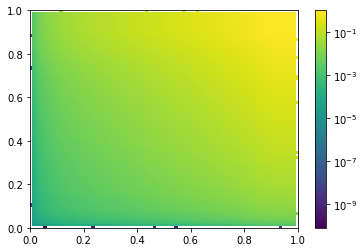

In [52]:
h = plt.hist2d(grid[:,0],grid[:,1],weights=cdf,norm=mpl.colors.LogNorm(),bins=100)
plt.colorbar(h[3])
plt.show()

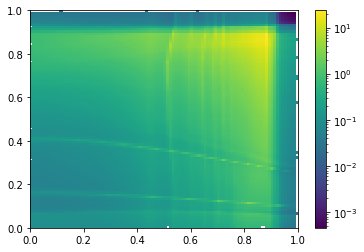

In [53]:
h = plt.hist2d(grid[:,0],grid[:,1],weights=pdf,norm=mpl.colors.LogNorm(),bins=100)
plt.colorbar(h[3])
plt.show()

In [54]:
x = tf.constant([0.8,0.2],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[0.8, 0.2]], dtype=float32), array([0.02913081], dtype=float32)]

In [55]:
x = tf.constant([1.0,1.0],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[1., 1.]], dtype=float32), array([nan], dtype=float32)]

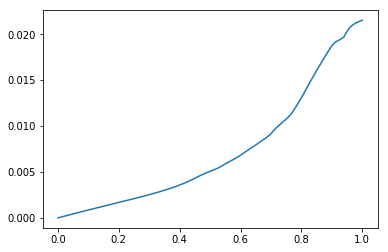

In [56]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.1])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

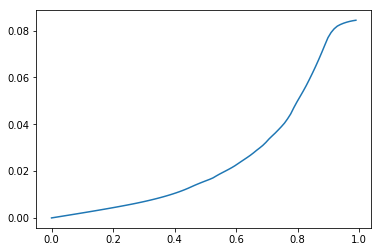

In [57]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.3])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

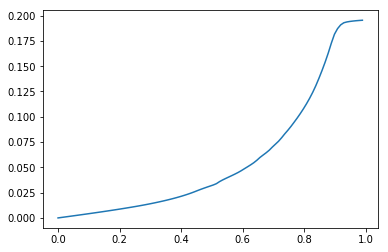

In [58]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.5])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

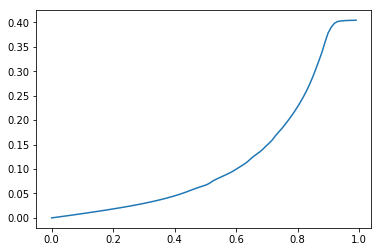

In [59]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.7])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

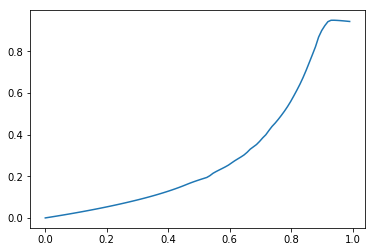

In [60]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.9])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()